# Classificação com BERT

Neste *notebook* você verá um exemplo de como usar o [BERT](https://arxiv.org/abs/1810.04805) para tarefa de classificação, usando Hugging Faces. 

Fontes:  

- [BERT Fine-Tuning Tutorial with PyTorch](https://mccormickml.com/2019/07/22/BERT-fine-tuning/).
- [Hugging Faces - Github](https://github.com/huggingface/transformers) e [Hugging Faces - site](https://huggingface.co/)


Primeiro, vamos verificar se temos GPU disponível para nossa execução. Não se preocupe caso não possua GPU, apenas o treinamento será mais demorado.

Caso você esteja executando no Colab, acesse: Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

In [21]:
import torch

# Verificar se tem GPU disponível
if torch.cuda.is_available():    

    # Informa PyTorch para usar GPU
    device = torch.device("cuda")

    print('Existe(m)  %d GPU(s) disponível(eis).' % torch.cuda.device_count())

    print('Vamos usar a GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('Sem GPU disponível, usando CPU.')
    device = torch.device("cpu")

Sem GPU disponível, usando CPU.


### Biblioteca Transformers com *pytorch*

Aqui vamos usar a interface *pytorch* porque possui um bom equilíbrio entre as APIs de alto nível (fáceis de usar, mas sem fornecer informações sobre como as coisas funcionam) e código de tensorflow (que contém muitos detalhes, mas não tão fáceis de usar).

No momento, a biblioteca **Hugging Face** é a interface *pytorch* mais utilizada para trabalhar com BERT. Além de oferecer suporte a uma variedade de modelos pré-treinados, também inclui modelos especifalizados para tarefas específicas. Neste tutorial vamos usar *BertForSequenceClassification*.

A biblioteca também inclui classes específicas de tarefas para classificação de *tokens*, resposta a perguntas (Q&A), previsão da próxima frase, etc. O uso dessas classes pré-construídas simplifica o processo de modificação de BERT para nossos propósitos.

In [3]:
# execute essa linha se estiver usando Colab
#!pip install transformers
!pip install transformers~=2.11.0


### Carregando o conjunto de dados (CoLA)

Usaremos o conjunto de dados do *Corpus of Linguistic Acceptability (CoLA)* para a classificação de uma única frase. É um conjunto de frases rotuladas como gramaticalmente corretas ou incorretas. Foi publicado pela primeira vez em maio de 2018, e é um dos testes incluídos no “Benchmark GLUE” em que competem modelos como o BERT.

Faça download do dataset neste link: https://nyu-mll.github.io/CoLA/ e descompacte o conjunto de dados na mesma pasta em que está trabalhando.

Ou, se estiver no Colab, use o comando abaixo:


In [ ]:
# Usaremos o wget para baixar o conjunto de dados para o sistema de arquivos da instância Colab.
!pip install wget

import wget
import os

print('Baixando dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')
    
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

### Análise

Podemos ver pelos nomes dos arquivos que temos as versões originais e as tokenizadas dos dados.

Não vamos usar a versão pré-tokenizada porque, para aplicar o nosso modelo BERT pré-treinado, devemos usar o tokenizer fornecido pelo modelo. Isso porque (1) o modelo tem um vocabulário específico e fixo e (2) o tokenizador BERT tem uma maneira particular de lidar com palavras fora do vocabulário.

Usaremos a biblioteca *pandas* para analisar o conjunto de treinamento e examinar algumas de suas propriedades.

In [5]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df = pd.read_csv(r"C:\Users\lisat\OneDrive\cola_public_1.1\cola_public\raw\in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Número de sentenças de treinamento: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Número de sentenças de treinamento: 8,551



,sentence_source,label,label_notes,sentence
2471,l-93,1,NaN,Sarah sang.
6427,d_98,1,NaN,All fugitives are in jail now.
3936,ks08,1,NaN,John coughed.
4404,ks08,0,*,There hopes to finish the project.
8284,ad03,0,*,Aphrodite wanted to live and Ishtar tried to do
5050,ks08,1,NaN,It surprised me that you came early.
4451,ks08,1,NaN,In no other circumstances does that distinctio...
2438,l-93,1,NaN,The lax supervision was taken advantage of.
173,cj99,0,*,"The more obnoxious Fred, the less you should p..."
6097,c_13,1,NaN,John left his wife.


As duas propriedades com as quais realmente nos importamos são as frases (*sentence*) e seus rótulos (*label*), que podem ser 0 = incorreta, 1 = correta.

Aqui estão cinco frases que são rotuladas como incorretas (gramaticalmente). Observe como essa tarefa é muito mais difícil do que algo como análise de sentimento!

In [6]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]


,sentence,label
3265,Bill dried at the clothes.,0
4262,Seems John to fix the computer.,0
1172,I know a man who John is as tall as is.,0
7669,John convinced that Bill has slept.,0
5643,The in loved peanut butter cookies.,0


Vamos extrair as frases e seus rótulos do nosso corpus de treinamento como *numpy ndarrays*.

In [7]:
# Lista de sentenças e seus rótulos
sentences = df.sentence.values
labels = df.label.values

### Tokenização

Agora vamos transformar nosso conjunto de dados no formato em que o BERT pode ser treinado.

Para alimentar o BERT com nosso texto, ele deve ser dividido em *tokens* e, em seguida, esses *tokens* devem ser mapeados para seu índice no vocabulário do tokenizador.

A tokenização deve ser realizada pelo tokenizador incluído no modelo BERT que estamos trabalhando, que vamos baixar no código abaixo.

In [8]:
from transformers import BertTokenizer

# Carregar o tokenizador BERT.
print('Carregando tokenizador BERT...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Carregando tokenizador BERT...


Vamos aplicar o tokenizer a uma frase apenas para ver a saída.

In [9]:
# Frase original
print(' Original: ', sentences[0])

# Frase dividida em tokens
print('Tokenizada: ', tokenizer.tokenize(sentences[0]))

# Sentença mapeada em token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenizada:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Quando realmente convertermos todas as nossas sentenças, usaremos a função ´´´tokenize.encode´´´ para lidar com ambas as etapas, em vez de chamar as funções que usamos acima separadamente.

Antes de fazermos isso, precisamos falar sobre alguns dos requisitos de formatação do BERT.

### Formatação

O código acima omitiu algumas etapas de formatação necessárias que veremos aqui.

Precisamos:
1. Adicione *tokens* especiais no início e fim de cada frase.
2. Agrupar e truncar todas as frases para terem o mesmo comprimento.
3. Diferenciar explicitamente *tokens* reais de *tokens* de preenchimento com a “máscara de atenção”.

**Tokens especiais**
[SEP] - No final de cada frase, precisamos acrescentar o token especial [SEP], que é usado em tarefas de duas sentenças, onde BERT recebe duas sentenças separadas e é solicitado a determinar algo (por exemplo, a resposta à pergunta na sentença A pode ser encontrada na sentença B).

[CLS] - Para tarefas de classificação, devemos acrescentar o [CLS] ao início de cada frase. Como o BERT consiste em 12 camadas de Tranformer, cada uma recebe uma lista de *embeddings* e produz o mesmo número de *embeddings* na saída (com outros valores), na saída do transformador final (12º), apenas o primeiro *embedding* (correspondente ao *token* [CLS]) é usado pelo classificador .

“O primeiro *token* de cada sequência é sempre um *token* de classificação especial ([CLS]), onde o estado oculto final deste *token* é usado como a representação da sequência agregada para tarefas de classificação.” (do artigo BERT)

Não precisamos pensar em estratégias de *pool* sobre os *embeddings* finais, pois nesse token [CLS] de classificação, o modelo codificou tudo o que precisamos para a classificação naquele único vetor de incorporação de 768 valores. Já está feito o *pool* para nós!

*Comprimento da frase e máscara de atenção*

As sentenças em nosso conjunto de dados obviamente têm comprimentos variados, então como o BERT lida com isso?

BERT tem duas restrições:

- Todas as frases devem ser preenchidas ou truncadas em um único comprimento fixo.
- O comprimento máximo da frase é 512 *tokens*.

O preenchimento é feito com um *token* especial [PAD], que está no índice 0 no vocabulário BERT.

A “Máscara de Atenção” é simplesmente uma matriz de 1s e 0s indicando quais *tokens* estão preenchendo e quais não estão (parece meio redundante, não é ?). Essa máscara diz ao mecanismo de “Autoatenção” do BERT para não incorporar esses *tokens* (PAD) em sua interpretação da frase.

O comprimento máximo afeta a velocidade de treinamento e avaliação. Por exemplo, com um Tesla K80:

MAX_LEN = 128 --> Cada época leva ~5:28 para treinar

MAX_LEN = 64 --> Cada época leva ~2:57 para treinar

**Tokenizar o conjunto de dados**

A biblioteca Transformers fornece uma função ´´´encode´´´ útil que tratará da maioria das etapas de análise e preparação de dados para nós.

Antes de estarmos prontos para codificar nosso texto, no entanto, precisamos decidir sobre o comprimento máximo de frase para preenchimento ou truncamento.

A célula abaixo realizará uma passagem de tokenização do conjunto de dados para medir o comprimento máximo da frase.

In [10]:
max_len = 0

# Para cada frase
for sent in sentences:

    # Tokeniza o texti e adiciona os tokens `[CLS]` e `[SEP]`
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Atualiza o comprimento máximo da frase
    max_len = max(max_len, len(input_ids))

print('Frase com tamanho máximo: ', max_len)

Frase com tamanho máximo:  47


Para o caso de haver algumas sentenças mais longas no conjunto de teste, o comprimento máximo será de 64.

Agora estamos prontos para realizar a tokenização.

A função ´´´tokenizer.encode_plus´´´ realiza várias etapas para nós:

1. Divide a frase em *tokens*.
2. Adiciona os *tokens* especiais [CLS] e [SEP].
3. Mapeia os *tokens* para seus IDs.
4. Preenche ou trunca todas as frases com o mesmo comprimento.
5. Cria as máscaras de atenção que diferenciam explicitamente *tokens* reais de *tokens* [PAD].

As primeiras quatro etapas são realizadas pela função ´´´tokenizer.encode´´´, mas vamos usar a ´´´tokenizer.encode_plus´´´ para a quinta etapa (máscaras de atenção). [Documentação aqui](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus)

In [11]:
# Tokeniza todas as frases e mapeia os tokens em seus IDs
input_ids = []
attention_masks = []

# Para cada frase
for sent in sentences:
    # `encode_plus` fará o seguinte:
    #   (1) Tokeniza a frase
    #   (2) Adiciona o token `[CLS]` no inicio
    #   (3) Adiciona o token `[SEP]` no final
    #   (4) Mapeia os tokens em seus IDs.
    #   (5) Adiciona preenchimento (pad) ou trunca a frase atá o comprimento máximo (`max_length`)
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Frase a ser codificada
                        add_special_tokens = True, # Adiciona '[CLS]' e '[SEP]'
                        max_length = 64,           # Preenche & trunca todas as frases
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Constrói máscaras de atenção
                        return_tensors = 'pt',     # Returna tensores pytorch.
                   )
    
    # Adiciona a frase codificada na lista
    input_ids.append(encoded_dict['input_ids'])
    
    # E sua máscara de atenção (simplesmente diferencia tokens reais de tokens de preenchimento - PAD).
    attention_masks.append(encoded_dict['attention_mask'])

# Converte a lista em tensores
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Imprime frase 0, agora como uma lista de IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\lisat\anaconda3\envs\torch\lib\site-packages\transformers\tokenization_utils_base.py:2136: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


### Divisão dos dados - treinamento e validação

Precisamos agora dividir nosso conjunto de treinamento, em 90% para treinamento e 10% para validação.


In [12]:
from torch.utils.data import TensorDataset, random_split

# Combina as entradas de treinamento em um TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Criar uma divisão 90-10 para treinamento-validação.

# Calcula o número de instâncias para incluir em cada divisão
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide o dataset pegando randomicamente as instância 
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} isntâncias de treinamento'.format(train_size))
print('{:>5,} instâncias de validação'.format(val_size))

7,695 isntâncias de treinamento
  856 instâncias de validação


Vamos criar um iterador para nosso conjunto de dados usando a classe DataLoader, para economizar memória durante o treinamento, visto que, ao contrário de um *loop* com *for*, com o iterador o conjunto de dados inteiro não precisa ser carregado na memória.

In [13]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# O DataLoader precisa saber no tamanho do batch size para treinamento, então vamos espeficiar
# Para o fine-tuning em uma tarefa, os autores recomendam um batch size de 16 ou 32.
batch_size = 16

# Criar os DataLoaders para nossos conjuntos de treinamento e teste
# Vamos pegar instâncias de treinamento em ordem aleatória
train_dataloader = DataLoader(
            train_dataset,  # Exemplos de treinamento
            sampler = RandomSampler(train_dataset), # Seleciona batches aleatoriamente
            batch_size = batch_size # Treina com este batch size.
        )

# Para validação, a ordem não importa, então vamos mantê-la sequencial
validation_dataloader = DataLoader(
            val_dataset, # Exemplos de validação.
            sampler = SequentialSampler(val_dataset), # Execita os batches sequencialmente.
            batch_size = batch_size # Avalia com este batch size.
        )

## Modelo de classificação##

Agora que nossos dados de entrada estão formatados corretamente, é hora de ajustar o modelo de BERT.

### BertForSequenceClassification

Para a tarefa de classificação, vamos modificar o modelo BERT pré-treinado para fornecer saídas para classificação e, em seguida, treinar todo modelo em nosso conjunto de dados até que esteja especializado para nossa tarefa.

Felizmente, a implementação do Hugging Face *pytorch* inclui um conjunto de interfaces projetadas para uma variedade de tarefas de PLN. Embora essas interfaces sejam todas construídas em cima de um modelo BERT treinado, cada uma tem diferentes camadas superiores e tipos de saída projetados para nossa tarefa PNL específica.

Aqui está a lista atual de classes fornecidas para a especialização da tarefa (ajuste fino ou *fine tuning*):

1. BertModel
1. BertForPreTraining
1. BertForMaskedLM
1. BertForNextSentencePrediction
1. BertForSequenceClassification (**usaremos aqui**)
1. BertForTokenClassification
1. BertForQuestionAnswering

A documentação para eles pode ser encontrada [aqui](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).

Estaremos usando *BertForSequenceClassification*, modelo BERT com uma camada linear única adicionada no topo para classificação, que será usado como um classificador de frases. À medida que alimentamos os dados de entrada, todo o modelo BERT pré-treinado e a camada adicional de classificação não treinada serão treinados em nossa tarefa específica.

OK, vamos carregar o BERT! Existem alguns modelos diferentes de BERT pré-treinados disponíveis. “bert-base-uncased” significa a versão que tem apenas letras minúsculas (“sem caixa”) e é a versão menor das duas (“base” vs “large”).

A documentação do método ```from_pretrained``` pode ser encontrada [aqui](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), com os parâmetros adicionais definidos [aqui](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Carrega a classe BertForSequenceClassification, o modelo pre-treinado com uma camada linear simples no topo
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Usa o BERT com 12 camadas, com vocabulario com caixa baixa
    num_labels = 2, # O número de saídas, ou rótulos, do nosso modelo (classificação binária em nosso caso)
                    # Para tarefas com mais classes (multi-classe), podemos aumentar esse número
    output_attentions = False, # Se o modelo deve retornar os pesos de atenção
    output_hidden_states = False, # Se o modelo deve retornar todos estados escondidos
)

# Se você tem GPU, configura o pytorch para executar o modelo na GPU
#model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Apenas por curiosidade, podemos navegar por todos os parâmetros do modelo.

Na célula abaixo, imprimimos os nomes e dimensões dos pesos para:

1. A camada de incorporação.
1. O primeiro dos doze transformadores.
1. A camada de saída.

In [15]:
# Lista todos os paremtros do modelo como uma lista de tuplas
params = list(model.named_parameters())

print('O modelo BERT tem {:} parâmetros diferentes.\n'.format(len(params)))

print('==== Camada de incorporação (Embedding) ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Primeiro Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Camada de Saída ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

O modelo BERT tem 201 parâmetros diferentes.

==== Camada de incorporação (Embedding) ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== Primeiro Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bia

## Otimizador e taxas de aprendizagem ##

Agora que carregamos nosso modelo, precisamos pegar os hiperparâmetros de treinamento de dentro do modelo armazenado.

Para fins de ajuste fino, os autores recomendam escolher entre os seguintes valores (do Apêndice A.3 do artigo de BERT ):

1. Tamanho do lote (*batch size*): 16, 32
1. Taxa de aprendizagem (*Adam*): 5e-5, 3e-5, 2e-5
1. Número de épocas: 2, 3, 4

Aqui vamos usar:

1. Tamanho do lote: 16 (definido ao criar nossos *DataLoaders*)
1. Taxa de aprendizagem: 2e-5
1. Épocas: 4 (veremos que provavelmente são muitas ...)

O parâmetro ```eps = 1e-8``` é “um número muito pequeno para evitar qualquer divisão por zero na implementação” (leia mais [aqui](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

Você pode encontrar a criação do otimizador *AdamW* em ```run_glue.py``` [aqui](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [16]:
# Nota: AdamW é uma classe da biblioteca huggingface
# Provavelmente o 'W' é de 'Weight Decay fix" ('Correção de redução de peso ")
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - o padrão é  5e-5, aqui usamos 2e-5
                  eps = 1e-8 # args.adam_epsilon  - o padrão é 1e-8.
                )

In [17]:
from transformers import get_linear_schedule_with_warmup

# Número de épocas de treinamento. Os autores do BERT recomendam entre 2 a 4. 
# Nós escolhemos 4, mas vamos ver depois que isso pode estar causando overfit nos dados de treinamento
epochs = 4

# Número total de passos de treinamento é [número de batches] x [número de épocas]. 
# (Note que não é o mesmo que o número de instâncias de treinamento).
total_steps = len(train_dataloader) * epochs

# Criando o programador de taxa de aprendizagem (learning rate scheduler.)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Valor padrão no run_glue.py
                                            num_training_steps = total_steps)

## *Loop* de treinamento ##

Abaixo está o nosso *loop* de treinamento. Há muita coisa acontecendo, mas fundamentalmente para cada passagem em nosso *loop*, temos uma fase de treinamento e uma fase de validação.

**Treinamento:**

1. Descompacta nossas entradas (dados e rótulos)
1. Carrega dados na GPU para aceleração (quando necessário)
1. Limpa os gradientes calculados na passagem anterior.
(No *pytorch*, os gradientes se acumulam por padrão (útil para coisas como RNNs), a menos que a gente limpe explicitamente)
1. Passo *Forward* (avanço), alimentando os dados de entrada pela rede
1. Passo *Backward* (para trás), ou retropropagação
1. Informa a rede para atualizar os parâmetros com ```optimizer.step ()```
1. Rastreia variáveis para monitorar o progresso

**Avaliação:**

1. Descompacta nossas entradas (dados e rótulos)
1. Carrega dados na GPU para aceleração (quando necessário)
1. Passo *Forward* (avanço), alimentando os dados de entrada pela rede
1. Calcula a perda (*loss*) em nossos dados de validação e rastreie variáveis para monitorar o progresso

*Pytorch* esconde todos os cálculos detalhados, mas comentamos o código para apontar quais das etapas acima estão acontecendo em cada linha.

No código abaixo, definimos uma função auxiliar para calcular a precisão.

In [18]:
import numpy as np

# Função para caluclar a acurácia das nossas perdições x rótulos
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Função auxiliar para formatar o tempo decorrido (hh:mm:ss)

In [19]:
import time
import datetime

def format_time(elapsed):
    '''
    Pega o tempo em segundos e retorna como hh:mm:ss
    '''
    # Arredonda
    elapsed_rounded = int(round((elapsed)))
    
    # Formata como hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

Estamos prontos para começar o treinamento!

In [27]:
import random
import numpy as np

# Esse código é baseado no `run_glue.py`
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Seta o valor 'seed' em todo lugar para tornar reproduzível
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Vamos guardar os valores de perda do treinamento e validação, acurária e tempos de execução.
training_stats = []

# Medir o total do tempo de treinamento para toda execução
total_t0 = time.time()

# para cada época
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Treinamento
    # ========================================
    
    # Executa um passo inteiro em todo conjunto de treinamento

    print("")
    print('======== Época {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Treinando...')

    # Mede quando tempo a época de treinamento demora
    t0 = time.time()

    # Reseta a perda total para esta época
    total_train_loss = 0

    # Coloca o modelo em modo de treinamento.
    # Essa chamada para `train` apenas muda o modo, mas não executa o treinamento.
    # as camadas `dropout` e `batchnorm` tem comportamento diferente durante o treinamento
    # (veja mais: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # Para cada batch dos nossos dados de treinamento
    for step, batch in enumerate(train_dataloader):

        # Atualiza progresso a cada 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calcula o tempo em minutos.
            elapsed = format_time(time.time() - t0)
            
            # Imprime o progresso.
            print('  Batch {:>5,}  de  {:>5,}.    Tempo: {:}.'.format(step, len(train_dataloader), elapsed))

        # Retira esse batch de treinamento do nosso dataloader. 
        #
        # Agora que retiramos esse batch, também vamos copiar cada tensor para a GPU usando o método `to`, se necessário.
        #
        # `batch` contém três tensores pytorch:
        #   [0]: ids de entrada 
        #   [1]: máscaras de atenção
        #   [2]: rótulos
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Sempre limpe qualquer gradiente calculado anteriormente antes de executar o passo de 
        # backward, pois o PyTorch não faz isso automaticamente, já que acumular os gradientes é
        # importante para o treinamento das RNNs. 
        # (https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Executa o passo forward (avalia o modelo no batch de treinamento).
        # Documentação para essa função: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # Retorna números diferentes de parâmetros, dependendo de qual argumento foi passado e quais flags foram setadas.
        # Aqui, vai retornar a perda (loss) e os "logits", saídas do modelo antes da ativação
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Acumula a perda do treinamento de todos os batches então podemos calcular a média da perda no final. 
        # `loss` é um Tensor contendo um valor único, a função `.item()` apenas retorna o valor Python do tensor.
        
        # com a versão nova do Transformers (4.x) aqui dá erro
        total_train_loss += loss.item()
        
        # Executa o passo backward para calcular os gradientes
        loss.backward()

        # Corte a norma dos gradientes para 1.0., para ajudar a prevenir o problema de "exploding gradients".
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Atualiza parâmetros e passa uma etapa usando o gradiente calculado.
        # O otimizador dita o "update rule", ou seja, como os parâmetros são modificados com base 
        # nos gradientes, taxa de aprendizagem, etc
        optimizer.step()

        # Atualiza taxa de aprendizagem
        scheduler.step()

    # Calcula a perda média sobre todos os batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Mede quanto tempo levou essa época
    training_time = format_time(time.time() - t0)

    print("")
    print("  Perda média do treinamento: {0:.2f}".format(avg_train_loss))
    print("  época de treinamento levou : {:}".format(training_time))
        
    # ========================================
    #               Validação
    # ========================================
    # Após a conclusão de cada época de treinamento, vamos medir nosso desempenho em nosso conjunto de validação;

    print("")
    print("Executando Validação...")

    t0 = time.time()

    # Coloca o modelo no modo de avaliação, ou seja, as camadas dropout terão comportamento diferente
    model.eval()

    # Variáveis de rastreamento
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Avalia os dados para uma época
    for batch in validation_dataloader:
        
        # Retira esse batch de treinamento do nosso dataloader. 
        #
        # Agora que retiramos o batch, vaos copiar cada tensor para nossa GPU com o método `to`, se estamos usando GPU
        #
        # `batch` contém 3 tensores pytorch:
        #   [0]: ids de entrada 
        #   [1]: máscaras de atenção
        #   [2]: rótulos
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Informa pytorch para não não se preocupar em construir o gráfico de computação durante o passo forward,
        # já que precisa apenas no passo backprop (treinamento).
        with torch.no_grad():        

            # Passo Forward, calcula as perdições logit.
            # token_type_ids é o mesmo que os "segment ids", que diferencia as sentenças 1 e 2 em uma tarefa com 2 sentenças
            # Documentação da função `model`: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Pega as saídas "logits" do model, valores prévios à aplicação da função de ativação como a softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Acumula a perda da validação
        total_eval_loss += loss.item()

        # Move os logits e rótulos para CPU, se necessário
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calcula a acurácia desse batch nas frases de teste, e acumula sobre todos os batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Imprime a acurácia final para a execução da validação.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Acurácia: {0:.2f}".format(avg_val_accuracy))

    # Calcula a média da perda sobre todos os batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Mede quanto tempo levou a validação
    validation_time = format_time(time.time() - t0)
    
    print("  Validação perda (Loss): {0:.2f}".format(avg_val_loss))
    print("  Validação levou: {:}".format(validation_time))

    # Grava as estatísticas para esta época.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Treinamento completo!")

print("Tempo total de treinamento {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Época 1 / 4 ========
Treinando...
  Batch    40  de    241.    Tempo: 0:00:09.
  Batch    80  de    241.    Tempo: 0:00:18.
  Batch   120  de    241.    Tempo: 0:00:26.
  Batch   160  de    241.    Tempo: 0:00:35.
  Batch   200  de    241.    Tempo: 0:00:44.
  Batch   240  de    241.    Tempo: 0:00:52.

  Perda média do treinamento: 0.09
  época de treinamento levou : 0:00:53

Executando Validação...
  Acurácia: 0.81
  Validação perda (Loss): 0.63
  Validação levou: 0:00:02

======== Época 2 / 4 ========
Treinando...
  Batch    40  de    241.    Tempo: 0:00:09.
  Batch    80  de    241.    Tempo: 0:00:17.
  Batch   120  de    241.    Tempo: 0:00:26.
  Batch   160  de    241.    Tempo: 0:00:35.
  Batch   200  de    241.    Tempo: 0:00:43.
  Batch   240  de    241.    Tempo: 0:00:52.

  Perda média do treinamento: 0.08
  época de treinamento levou : 0:00:52

Executando Validação...
  Acurácia: 0.81
  Validação perda (Loss): 0.63
  Validação levou: 0:00:02

======== Época 3 / 4 

Vamos ver o resumo do processo de treinamento.

In [22]:
import pandas as pd

# Mostra números com duas casas decimais
pd.set_option('precision', 2)

# Cria um DataFrame das nossas estatísticas de treinamento
df_stats = pd.DataFrame(data=training_stats)

# Usa a época como o índice da linha
df_stats = df_stats.set_index('epoch')

# Forçar o agrupamento dos cabeçalho da coluna 
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Mostra a tabela
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.51,0.45,0.79,0:00:52,0:00:02
2,0.33,0.48,0.80,0:00:52,0:00:02
3,0.22,0.57,0.80,0:00:52,0:00:02
4,0.16,0.63,0.81,0:00:52,0:00:02


Observe que, enquanto a perda de treinamento está diminuindo a cada época, a perda de validação está aumentando! Isso sugere que estamos treinando nosso modelo por muito tempo e que ele está se ajustando demais aos dados de treinamento.

(Para referência, estamos usando 7.695 amostras de treinamento e 856 amostras de validação).

A perda de validação é uma medida mais precisa do que a precisão, porque com a precisão não nos importamos com o valor de saída exato, mas apenas em que lado de um limite ele cai.

Se estivermos prevendo a resposta correta, mas com menos confiança, a perda de validação pegará isso, mas a precisão não.

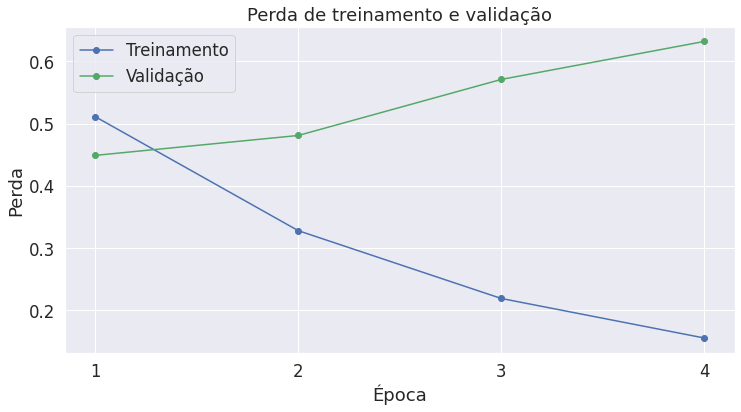

In [24]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Usando estilo
sns.set(style='darkgrid')

# Aumentando o tamanho e fonte 
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plotando a curva de aprendizagem
plt.plot(df_stats['Training Loss'], 'b-o', label="Treinamento")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validação")


# Adicionando títulos
plt.title("Perda de treinamento e validação")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

## Desempenho no conjunto de teste ##

Agora, carregaremos o conjunto de dados *holdout* e preparar as entradas, como fizemos com o conjunto de treinamento. 

Em seguida, avaliaremos as previsões usando o [coeficiente de correlação de Matthew](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html), métrica usada para avaliar o desempenho no CoLA. Com essa métrica, +1 é a melhor pontuação e -1 é a pior pontuação. Dessa forma, podemos ver nosso desempenho em relação aos modelos de última geração para essa tarefa específica.

### Preparação de dados ###

Precisaremos aplicar todas as mesmas etapas que fizemos para os dados de treinamento para preparar nosso conjunto de dados de teste.



In [25]:
import pandas as pd

# Carrega o dataset em um dataframe pandas
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Imprime o número de frases
print('Número de frases de teste: {:,}\n'.format(df.shape[0]))

# Cria as listas de frases e rótulos
sentences = df.sentence.values
labels = df.label.values

# Tokeniza todas as sentenças e mapeia os tokens em seus IDs.
input_ids = []
attention_masks = []

# Para cada frase
for sent in sentences:
    # `encode_plus` vai:
    #   (1) Tokenizar a frase
    #   (2) Adicionar o token `[CLS]` no início
    #   (3) Adicionar o token `[SEP]` no final.
    #   (4) Mapear tokens aos seus IDs.
    #   (5) Preencher ou truncar a frase até `max_length`
    #   (6) Criar máscara de atenção para os tokens [PAD].
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentença a ser codificada
                        add_special_tokens = True, # Adiciona '[CLS]' e '[SEP]'
                        max_length = 64,           # Preenche & trunca todas as sentenças
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Constrói máscara de atenção
                        return_tensors = 'pt',     # Retorna tensores pytorch.
                   )
    
    # Adiciona a sentença codificada na lista
    input_ids.append(encoded_dict['input_ids'])
    
    # E sua máscara de atenção (simplesmente diferencia preenchimento (PAD) de não-pad).
    attention_masks.append(encoded_dict['attention_mask'])

# Converte as listas em tensores.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Seta o batch size.  
batch_size = 32  

# Cria o DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Número de frases de teste: 516



### Avaliação no conjunto de teste ###

Com o conjunto de teste preparado, podemos aplicar nosso modelo ajustado para gerar previsões no conjunto de teste.

In [26]:
# Predição no conjunto de teste

print('Predição de rótulos para {:,} frases de teste...'.format(len(input_ids)))

# coloca o modele em modo de avaliação
model.eval()

# Variáveis de rastreamento
predictions , true_labels = [], []

# Predição 
for batch in prediction_dataloader:
  # Adiciona o batch na GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Retira as entradas do dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Informa o modelo para não computar gradientes, salvando memória e acelerando a predição 
  with torch.no_grad():
      # Passo Forward, calcula as predições logit
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move as logits e rótulos para CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Armazen predições e rótulos verdadeiros
  predictions.append(logits)
  true_labels.append(label_ids)

print('    FIM.')

Predição de rótulos para 516 frases de teste...
    FIM.


A precisão no *benchmark* CoLA é medida usando o “coeficiente de correlação de Matthews” (MCC).

Usamos MCC aqui porque as classes são desequilibradas:

In [27]:
print('Instâncias positivas: %d de %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))


Instâncias positivas: 354 de 516 (68.60%)


In [28]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Avaliando cada batch de teste usando MCC
print('Calculando MCC para cada batch...')

# Para cada batch
for i in range(len(true_labels)):
  
  # As predições para este batch são a 2a. coluna do ndarray (uma coluna para "0" e outra para "1"  
  # Pega o rótulo com o maior valor e transforma para uma lista de 0s e 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calcula e armazena o coef para este batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculando MCC para cada batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


A pontuação final será baseada em todo o conjunto de teste, mas vamos dar uma olhada nas pontuações dos lotes individuais para ter uma noção da variabilidade da métrica entre os lotes.

Cada lote contém 32 sentenças, exceto o último lote que contém apenas (516% 32) = 4 sentenças de teste.

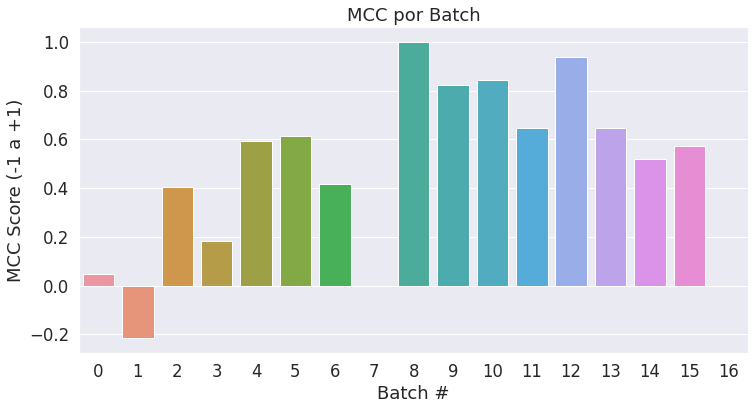

In [29]:
# Cria um barplot mostrando o MCC para cada batch dos nossos exemplos de teste.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC por Batch')
plt.ylabel('MCC Score (-1 a +1)')
plt.xlabel('Batch #')

plt.show()

Agora combinaremos os resultados de todos os lotes e calcularemos nossa pontuação final no MCC.

In [30]:
# Combina os resultados para todos os batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# Para cada exemplo, pega o rótulo (0 or 1) com maior score
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combina os rótulos corretor para cada batch em uma única lista.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calcula o MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.550


Legal! Em cerca de meia hora e sem fazer nenhum ajuste de hiperparâmetro (ajustando a taxa de aprendizagem, épocas, tamanho do lote, propriedades ADAM, etc.), obtivemos uma boa pontuação.

Nota: Para maximizar a pontuação, devemos remover o “conjunto de validação” (que usamos para ajudar a determinar em quantas épocas treinar) e treinar em todo o conjunto de treinamento.

A biblioteca documenta a precisão esperada para este benchmark aqui como **49.23** ([ver tabela de classificação oficial](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy)).

## Conclusão ##

Com um modelo BERT pré-treinado, podemos criar de forma rápida e eficaz um modelo de alta qualidade com o mínimo de esforço e tempo de treinamento usando a interface *pytorch*, independentemente da tarefa PLN específica em que estamos interessados.

### Salvar e carregar modelo ajustado ###

A próxima célula grava o modelo e o tokenizer no disco.

In [31]:
import os

# Boa-prática: usar os nomes padrão dos modlos, para fazer load usando from_pretrained()

output_dir = './model_save/'

# Criar diretório de saída se necessário
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Savando modelo em %s" % output_dir)

# Salva um modelo treinado, sua configuração e tokenizador com `save_pretrained()`.
# Eles podem ser carregados com `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Cuida do treinamento paralelo/distribuído
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Boa-prática: salve os argumentos de treinamento junto com o modelo
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Savando modelo em ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

Vamos verificar os tamanhos dos arquivos, por curiosidade. (no Colab)

In [32]:
!ls -l --block-size=K ./model_save/


total 427996K
-rw-r--r-- 1 root root      1K Dec 10 19:33 config.json
-rw-r--r-- 1 root root 427752K Dec 10 19:33 pytorch_model.bin
-rw-r--r-- 1 root root      1K Dec 10 19:33 special_tokens_map.json
-rw-r--r-- 1 root root      1K Dec 10 19:33 tokenizer_config.json
-rw-r--r-- 1 root root    227K Dec 10 19:33 vocab.txt


O maior arquivo é o peso do modelo, em torno de 418 megabytes.



In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin


Para salvar seu modelo nas sessões do **Colab Notebook**, baixe-o em sua máquina local ou, de preferência, copie-o para o Google Drive.

In [ ]:
# Montando Google Drive nesta instância 
from google.colab import drive
    drive.mount('/content/drive')
    
# Copia os arquivos do modelo num diretório do Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/PLN/BERT Fine-Tuning/"

As funções a seguir carregarão o modelo de volta do disco.



In [ ]:
# Carrega um modelo treinado e seu vocabulário
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copia o modelo na GPU
model.to(device)